# **Clustering lynx**

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import timm
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from scipy.stats import norm
from safetensors import safe_open

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from oml.functional.metrics import calc_cmc, calc_map, calc_precision
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

import timm

from lynx_id.data.dataset import LynxDataset
from lynx_id.data.transformations_and_augmentations import transforms_megadescriptor as transforms
from lynx_id.data.collate import collate_single
from lynx_id.model.embeddings import EmbeddingModel
from lynx_id.model.clustering import ClusteringModel
from lynx_id.eval.eval import EvalMetrics
from lynx_id.utils.plot_results import plot_multiple_bar

plt.rcParams['figure.figsize'] = [20, 5]

def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        
seed_everything(53)

/lustre/fswork/projects/rech/ads/uxp55sd/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/lustre/fswork/projects/rech/ads/uxp55sd/.local/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.3.0+py3.11.5/lib/python3.11/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

DEVICE='cuda'


## **Prepare data**

### Load datasets

In [4]:
probabilities = [0, 0.5, 0.5]

BASE_PATH = Path("/lustre/fsn1/projects/rech/ads/commun/datasets/balanced_noswiss_csv")
countries = ['all']
image_size = 384

train_lynxDataset = LynxDataset(
    dataset_csv=Path(BASE_PATH / 'lynx_id_balanced_train.csv'),
    countries=countries,
    loader="pil",
    transform=transforms(image_size=image_size),
    augmentation=None,
    probabilities=probabilities,
    mode='single',
    device="auto"
)

val_lynxDataset = LynxDataset(
    dataset_csv=Path(BASE_PATH / 'lynx_id_balanced_val.csv'), 
    countries=countries,
    loader="pil",
    transform=transforms(image_size=image_size),
    augmentation=None,
    probabilities=probabilities,
    mode='single',
    device="auto"
)  # useful for computing the threshold for detecting new individuals when evaluating the test set

test_lynxDataset = LynxDataset(
    dataset_csv=Path(BASE_PATH / 'lynx_id_balanced_test.csv'), 
    countries=countries,
    loader="pil",
    transform=transforms(image_size=image_size),
    augmentation=None,
    probabilities=probabilities,
    mode='single',
    device="auto"
)

In [5]:
print(f"{len(train_lynxDataset)=} images")
print(f"{len(val_lynxDataset)=} images")
print(f"{len(test_lynxDataset)=} images")

len(train_lynxDataset)=8647 images
len(val_lynxDataset)=2059 images
len(test_lynxDataset)=2526 images


In [6]:
train_lynx_id_counts = train_lynxDataset.dataframe['lynx_id'].value_counts()
val_lynx_id_counts = val_lynxDataset.dataframe['lynx_id'].value_counts()
test_lynx_id_counts = test_lynxDataset.dataframe['lynx_id'].value_counts()


print(f"TRAIN | Number of individuals: {len(train_lynx_id_counts)}")
print(f"VAL   | Number of individuals: {len(val_lynx_id_counts)}")
print(f"TEST  | Number of individuals: {len(test_lynx_id_counts)}")

TRAIN | Number of individuals: 732
VAL   | Number of individuals: 585
TEST  | Number of individuals: 789


In [7]:
set_individuals_train = set(train_lynx_id_counts.index)
set_individuals_val = set(val_lynx_id_counts.index)
set_individuals_test = set(test_lynx_id_counts.index)

print(f"The train and val set share {len(set_individuals_train.intersection(set_individuals_val))} individuals in common.")
print(f"Compared to the training set, the val set has {len(set_individuals_val - set_individuals_train)} new individuals.\n")

print(f"The train and test set share {len(set_individuals_train.intersection(set_individuals_test))} individuals in common.")
print(f"Compared to the training set, the test set has {len(set_individuals_test - set_individuals_train)} new individuals.")

The train and val set share 487 individuals in common.
Compared to the training set, the val set has 98 new individuals.

The train and test set share 671 individuals in common.
Compared to the training set, the test set has 118 new individuals.


In [8]:
new_lynx_id_val = set_individuals_val - set_individuals_train
new_lynx_id_test = set_individuals_test - set_individuals_train

In [9]:
train_dataloader = DataLoader(
    train_lynxDataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single,
    prefetch_factor=4
)

val_dataloader = DataLoader(
    val_lynxDataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single,
    prefetch_factor=4
)

test_dataloader = DataLoader(
    test_lynxDataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single,
    prefetch_factor=4
)

### Load our best model to get embeddings from image

In [10]:
model = timm.create_model(
    "swin_large_patch4_window12_384",
    pretrained=True, 
    # features_only=True, 
    num_classes=0,
    pretrained_cfg_overlay={'file': '/lustre/fswork/projects/rech/ads/commun/models/MegaDescriptor-L-384/pytorch_model.bin'}
).to("cuda")
model = model.eval()

/lustre/fswork/projects/rech/ads/uxp55sd/.local/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.3.0+py3.11.5/lib/python3.11/site-packages/timm/models/_helpers.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will n

In [11]:
train_embeddings=None

for i, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
    batch_tensor = torch.stack(batch[0]['image']).to(DEVICE).float()

    with torch.no_grad():
        batch_embeddings = model(batch_tensor)

        if train_embeddings is None:
            train_embeddings = batch_embeddings
        else:
            train_embeddings = torch.cat((train_embeddings, batch_embeddings), dim=0)

100%|##########| 136/136 [02:18<00:00,  1.02s/it]


In [12]:
val_embeddings=None

for i, batch in enumerate(tqdm(val_dataloader, total=len(val_dataloader))):
    batch_tensor = torch.stack(batch[0]['image']).to(DEVICE).float()

    with torch.no_grad():
        batch_embeddings = model(batch_tensor)

        if val_embeddings is None:
            val_embeddings = batch_embeddings
        else:
            val_embeddings = torch.cat((val_embeddings, batch_embeddings), dim=0)

100%|##########| 33/33 [00:33<00:00,  1.03s/it]


In [13]:
test_embeddings=None

for i, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
    batch_tensor = torch.stack(batch[0]['image']).to(DEVICE).float()

    with torch.no_grad():
        batch_embeddings = model(batch_tensor)

        if test_embeddings is None:
            test_embeddings = batch_embeddings
        else:
            test_embeddings = torch.cat((test_embeddings, batch_embeddings), dim=0)

100%|##########| 40/40 [00:40<00:00,  1.02s/it]


In [14]:
train_embeddings = train_embeddings.to("cpu")
val_embeddings = val_embeddings.to("cpu")
test_embeddings = test_embeddings.to("cpu")

print(f"TRAIN | Number of images: {train_embeddings.shape[0]} | Embedding shape: {train_embeddings.shape[1]}")
print(f"VAL   | Number of images: {val_embeddings.shape[0]}   | Embedding shape: {val_embeddings.shape[1]}")
print(f"TEST  | Number of images: {test_embeddings.shape[0]}  | Embedding shape: {test_embeddings.shape[1]}")

TRAIN | Number of images: 8647 | Embedding shape: 1536
VAL   | Number of images: 2059   | Embedding shape: 1536
TEST  | Number of images: 2526  | Embedding shape: 1536


In [25]:
val_lynx_id = val_lynxDataset.compute_new_lynx_id(train_lynxDataset)
test_lynx_id = test_lynxDataset.compute_new_lynx_id(train_lynxDataset)

100%|##########| 2059/2059 [00:00<00:00, 5414465.16it/s]


count_new=220


100%|##########| 2526/2526 [00:00<00:00, 5770594.72it/s]


count_new=279


In [26]:
# Check that we have new individuals
assert "New" in test_lynx_id
assert "New" in val_lynx_id

## **KNN**

In [27]:
train_lynx_infos = train_lynxDataset.dataframe[['lynx_id', 'date', 'location', 'filepath']].copy()

clustering_model = ClusteringModel(
    embeddings_knowledge=train_embeddings,
    lynx_infos_knowledge=train_lynx_infos,
    n_neighbors=5,
    algorithm="brute",
    metric="minkowski",
)

### Validation set

First, we cluster our validation set. This will allow us to evaluate its accuracy without detecting any new candidates.  
**Then, to detect new individuals, we'll test different thresholds to find the best one. This will be used to evaluate the test set.**

In [28]:
# Nearest Neighbors
val_candidates_nearest_neighbors = clustering_model.clustering(val_embeddings)

In [29]:
top_k = (1, 2, 3, 4, 5)

val_eval_metrics = EvalMetrics(
    candidates_nearest_neighbors=clustering_model.candidates_nearest_neighbors,
    lynx_id_true=val_lynx_id,
    top_k=top_k
)

In [30]:
accuracy_no_threshold = val_eval_metrics.compute_accuracy(lynx_id_predicted=clustering_model.one_knn())
print(f"Accuracy 1-KNN: {accuracy_no_threshold}")

Accuracy 1-KNN: 0.1913550267119961


In [31]:
val_best_threshold = val_eval_metrics.get_best_threshold(
    clustering_model=clustering_model,
    min_threshold=0.0,
    max_threshold=50.0,
    step=0.1
)
val_best_threshold

20.400000000000002

We do a visual check and calculate the precision/recall for the New individual.

In [32]:
thresholds = np.arange(val_best_threshold-10, val_best_threshold+10+0.5, 0.5)

score_threshold = {'precision': [], 'recall': [], 'accuracy': []}

for threshold in thresholds:
    candidates_predicted_new_individual = clustering_model.check_new_individual(
        candidates_predicted=clustering_model.one_knn(),
        threshold=threshold,
    )
    
    precision_recall = val_eval_metrics.precision_recall_individual(
        candidates_predicted=candidates_predicted_new_individual, 
        individual_name="New",
        verbose=False
    )

    accuracy_threshold = val_eval_metrics.compute_accuracy(
        lynx_id_predicted=candidates_predicted_new_individual,
    )
    
    score_threshold['precision'].append(precision_recall['precision'])
    score_threshold['recall'].append(precision_recall['recall'])
    score_threshold['accuracy'].append(accuracy_threshold)

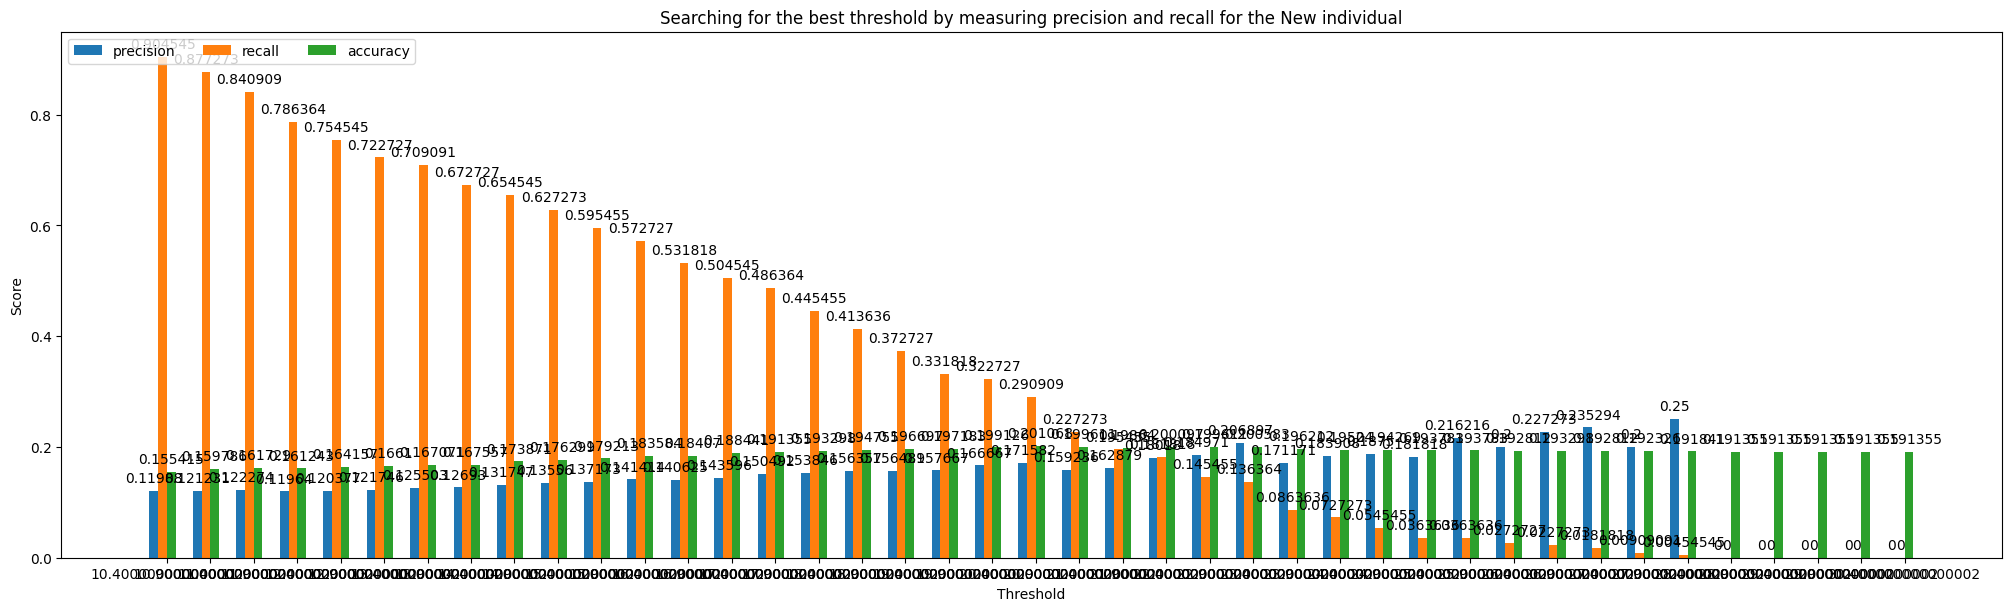

In [33]:
plot_multiple_bar(
    values=score_threshold,
    x_values=thresholds,
    xlabel="Threshold",
    ylabel="Score",
    title="Searching for the best threshold by measuring precision and recall for the New individual"
)

### Test set

#### CMC@k, mAP@k
We use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k** and **mAP@k**.

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as new, will have "New" as its nearest neighbour, then its neighbours calculated via KNN will be shifted by 1. The last one is therefore forgotten.  

Example:  
candidate i: `["A", "B", "C", "D"]` detected as New -> `["New", "A", "B", "C", "D"]`

In [34]:
top_k = (1, 2, 3, 4, 5)

clustering_model.clustering(test_embeddings)

test_eval_metrics = EvalMetrics(
    candidates_nearest_neighbors=clustering_model.candidates_nearest_neighbors,
    lynx_id_true=test_lynx_id,
    top_k=top_k
)

Computation of accuracy without detection of new candidates with 1-KNN.

In [35]:
accuracy_no_threshold = test_eval_metrics.compute_accuracy(lynx_id_predicted=clustering_model.one_knn())
print(f"Accuracy 1-KNN no threshold : {accuracy_no_threshold}")

accuracy_no_threshold_no_new = test_eval_metrics.compute_accuracy(lynx_id_predicted=clustering_model.one_knn(), no_new=True)
print(f"Accuracy 1-KNN no threshold + no new : {accuracy_no_threshold_no_new}")

Accuracy 1-KNN no threshold : 0.18448139350752177
Accuracy 1-KNN no threshold + no new : 0.20738762794837562


#### Ideal threshold

We won't be using it to evaluate our test set. We'll use the one obtained from the validation set.

In [36]:
theorical_best_threshold = test_eval_metrics.get_best_threshold(
    clustering_model=clustering_model,
    min_threshold=0.0,
    max_threshold=50.0,
    step=0.1
)
theorical_best_threshold

20.1

In [37]:
thresholds = np.arange(theorical_best_threshold-10, theorical_best_threshold+10+0.5, 0.5)

score_threshold = {'precision': [], 'recall': [], 'accuracy': []}

for threshold in thresholds:
    candidates_predicted_new_individual = clustering_model.check_new_individual(
        candidates_predicted=clustering_model.one_knn(),
        threshold=threshold,
    )
    
    precision_recall = test_eval_metrics.precision_recall_individual(
        candidates_predicted=candidates_predicted_new_individual, 
        individual_name="New",
        verbose=False
    )

    accuracy_threshold = test_eval_metrics.compute_accuracy(
        lynx_id_predicted=candidates_predicted_new_individual,
    )
    
    score_threshold['precision'].append(precision_recall['precision'])
    score_threshold['recall'].append(precision_recall['recall'])
    score_threshold['accuracy'].append(accuracy_threshold)

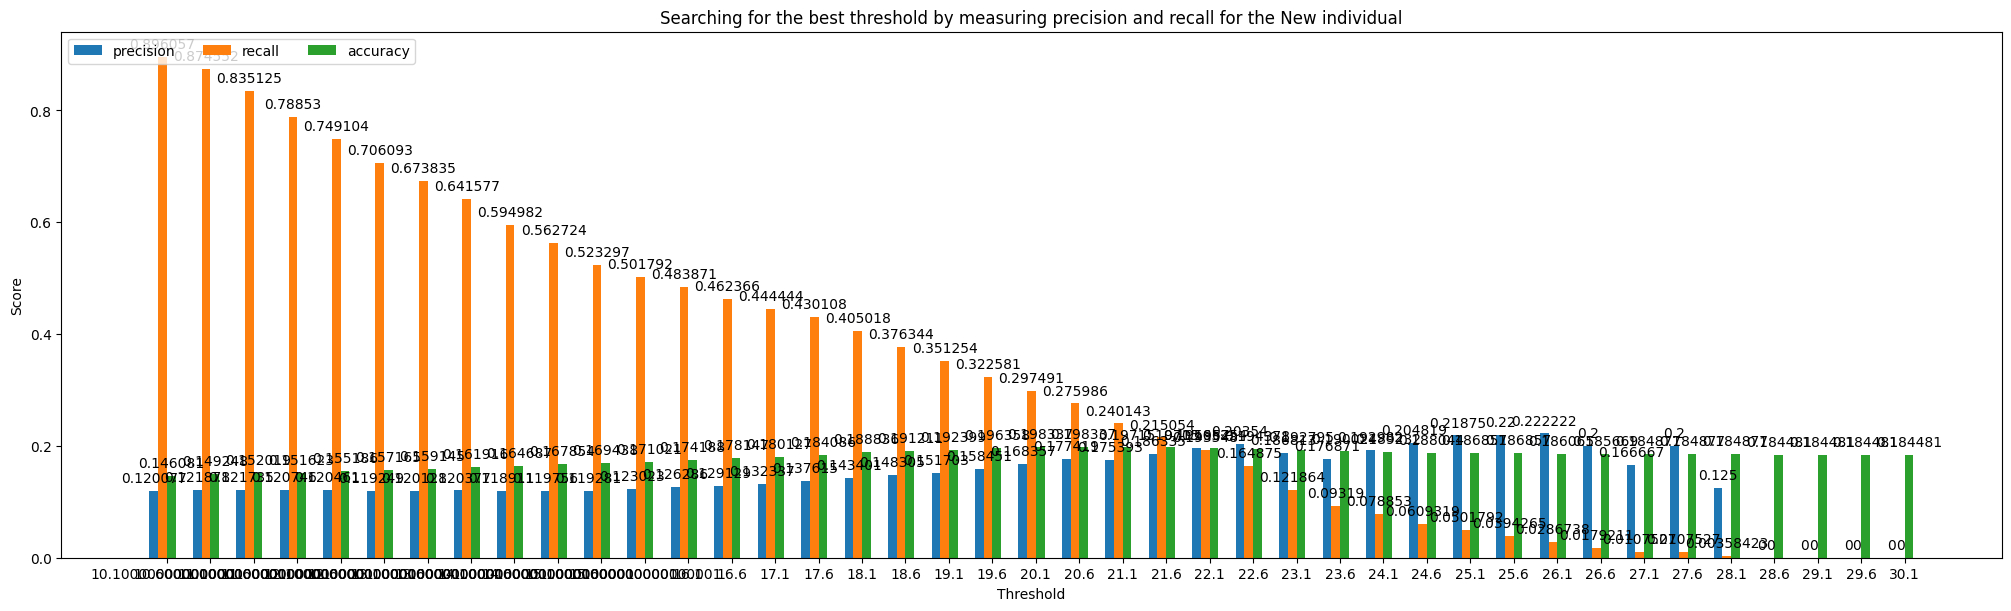

In [38]:
plot_multiple_bar(
    values=score_threshold,
    x_values=thresholds,
    xlabel="Threshold",
    ylabel="Score",
    title="Searching for the best threshold by measuring precision and recall for the New individual"
)

#### Metric computation

In [39]:
cmc_values = {}
map_values = {}

In [40]:
### Threshold ###
print("-"*50, "New individual based on threshold", "-"*50)
print(f"Threshold used: {val_best_threshold}\n")
candidates_predicted_new_individual = clustering_model.check_new_individual(
    embeddings=test_embeddings,
    candidates_predicted=clustering_model.one_knn(),
    threshold=val_best_threshold,
)

precision_recall = test_eval_metrics.precision_recall_individual(
    candidates_predicted=candidates_predicted_new_individual, 
    individual_name="New",
    verbose=True
)
print(precision_recall)

accuracy_threshold = test_eval_metrics.compute_accuracy(
    lynx_id_predicted=candidates_predicted_new_individual,
)
print(f"Accuracy 1-KNN threshold: {accuracy_threshold}")


# CMC@k + mAP@k
candidates_nearest_neighbors_new = clustering_model.compute_candidates_nearest_neighbors_new(
    candidates_predicted_new_individual=candidates_predicted_new_individual
)
test_eval_metrics.candidates_nearest_neighbors = candidates_nearest_neighbors_new
cmc_k_mean, map_k_mean = test_eval_metrics.compute_cmc_map_metrics()
print(f"{cmc_k_mean=}")
print(f"{map_k_mean=}")
cmc_values['threshold'] = list(cmc_k_mean.values())
map_values['threshold'] = list(map_k_mean.values())

-------------------------------------------------- New individual based on threshold --------------------------------------------------
Threshold used: 20.400000000000002

New individual predicted 452 times (total number of images: 2526). In reality, the New individual appears 279 times.
{'precision': 0.17256637168141592, 'recall': 0.27956989247311825}
Accuracy 1-KNN threshold: 0.19833729216152018
cmc_k_mean={1: 0.198, 2: 0.257, 3: 0.29, 4: 0.315, 5: 0.332}
map_k_mean={1: 0.198, 2: 0.227, 3: 0.237, 4: 0.24, 5: 0.243}


#### Unbalanced evaluation ?

In [41]:
y_true = test_eval_metrics.lynx_id_true
y_pred = [candidate.lynx_id for candidate in candidates_predicted_new_individual]

In [42]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_true, y_pred)
confusion_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
with np.errstate(divide="ignore", invalid="ignore"):
    per_class = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)
    per_class = [(value, row_sum) for value, row_sum in zip(per_class, confusion_matrix.sum(axis=1))]

per_class_df = pd.DataFrame(per_class, columns=['accuracy', 'number of images'])
per_class_df

,accuracy,number of images
0,0.000000,1
1,0.000000,1
2,0.000000,1
3,0.000000,1
4,0.000000,6
...,...,...
673,0.000000,7
674,0.307692,13
675,0.000000,1
676,0.000000,2


Note: NaN accuracy with a number of images equal to 0, perhaps caused by the fact that our model predicts a lynx_id not present in the test set. This was present in the training set, so it can predict it.

#### Balanced accuracy

To avoid giving too much importance to certain very present lynx_ids.

In [44]:
per_class_score = [score[0] for score in per_class]

balanced_accuracy = np.mean(np.nan_to_num(per_class_score, nan=0))
balanced_accuracy

0.09336749653593236

In [45]:
from sklearn.metrics import precision_score, recall_score

print(f"Precision score (unweighted/macro): {precision_score(y_true, y_pred, average='macro', zero_division=0)}")
print(f"Recall score (unweighted/macro): {recall_score(y_true, y_pred, average='macro', zero_division=0)}")

Precision score (unweighted/macro): 0.0943846960136235
Recall score (unweighted/macro): 0.09336749653593236


#### Accuracy without taking “New” images into account 

In [46]:
y_true_array = np.array(y_true)
y_pred_array = np.array(y_pred)

known = y_true_array != "New"

np.mean(y_true_array[known] == y_pred_array[known])

0.1882510013351135

#### Accuracy taking only “New” images into account 

In [47]:
unknown = y_true_array == "New"
np.mean(y_true_array[unknown] == y_pred_array[unknown])  # = recall New

0.27956989247311825

#### Detection of new candidates using the Gaussian method

Based on the Gaussian distribution of the clusters in the train.

In [48]:
### Gaussian ###
print("\n", "-"*50, "New individual based on gaussian", "-"*50)

accuracy_list = []
n_neighbors=5
confidence_levels = [0.68, 0.95, 0.997]

for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    results = []
    for k, prediction in {"1_knn": clustering_model.one_knn(), f"{n_neighbors}_knn": clustering_model.n_knn()}.items():
        clustering_model.clustering(test_embeddings)
        candidates_predicted_new_individual = clustering_model.check_new_individual(
            embeddings=test_embeddings,
            candidates_predicted=prediction,
            success_percentage_threshold=80,
            confidence=confidence
        )
        
        accuracy = test_eval_metrics.compute_accuracy(
            lynx_id_predicted=candidates_predicted_new_individual,
        )
        print(f"Accuracy {k}: {accuracy}")
        results.append(accuracy)
        
        candidates_nearest_neighbors_new = clustering_model.compute_candidates_nearest_neighbors_new(
            candidates_predicted_new_individual=candidates_predicted_new_individual
        )
        test_eval_metrics.candidates_nearest_neighbors = candidates_nearest_neighbors_new
    
        # CMC@k + mAP@k
        cmc_k_mean, map_k_mean = test_eval_metrics.compute_cmc_map_metrics()
        print(f"{cmc_k_mean=}")
        print(f"{map_k_mean=}")
        
        if k == "1_knn":
            cmc_values[confidence] = list(cmc_k_mean.values())
            map_values[confidence] = list(map_k_mean.values())

    
    accuracy_list.append(results)


 -------------------------------------------------- New individual based on gaussian --------------------------------------------------
************************************************** 0.68 **************************************************


  0%|          | 1/732 [00:00<01:14,  9.85it/s]/gpfsdswork/projects/rech/ads/uxp55sd/DP-SCR_Identify-and-estimate-density-lynx-population/lynx_id/model/clustering.py:156: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  self.cluster_variances[lynx] = torch.var(self.embeddings_knowledge[lynx_idx], dim=0).tolist()
compute_confidence_intervals: 100%|##########| 732/732 [00:00<00:00, 1470.53it/s]


Accuracy 1_knn: 0.13499604117181313
cmc_k_mean={1: 0.135, 2: 0.288, 3: 0.335, 4: 0.366, 5: 0.386}
map_k_mean={1: 0.135, 2: 0.212, 3: 0.231, 4: 0.24, 5: 0.245}


compute_confidence_intervals: 100%|##########| 732/732 [00:00<00:00, 1616.14it/s]


Accuracy 5_knn: 0.13539192399049882
cmc_k_mean={1: 0.136, 2: 0.287, 3: 0.336, 4: 0.366, 5: 0.386}
map_k_mean={1: 0.136, 2: 0.212, 3: 0.232, 4: 0.24, 5: 0.245}
************************************************** 0.95 **************************************************


compute_confidence_intervals: 100%|##########| 732/732 [00:00<00:00, 1500.26it/s]


Accuracy 1_knn: 0.19002375296912113
cmc_k_mean={1: 0.19, 2: 0.247, 3: 0.282, 4: 0.305, 5: 0.324}
map_k_mean={1: 0.19, 2: 0.219, 3: 0.228, 4: 0.231, 5: 0.233}


compute_confidence_intervals: 100%|##########| 732/732 [00:00<00:00, 1509.70it/s]


Accuracy 5_knn: 0.1868566904196358
cmc_k_mean={1: 0.19, 2: 0.248, 3: 0.281, 4: 0.304, 5: 0.324}
map_k_mean={1: 0.19, 2: 0.219, 3: 0.228, 4: 0.231, 5: 0.233}
************************************************** 0.997 **************************************************


compute_confidence_intervals: 100%|##########| 732/732 [00:00<00:00, 1514.14it/s]


Accuracy 1_knn: 0.1880443388756928
cmc_k_mean={1: 0.188, 2: 0.238, 3: 0.27, 4: 0.293, 5: 0.312}
map_k_mean={1: 0.188, 2: 0.213, 3: 0.221, 4: 0.224, 5: 0.226}


compute_confidence_intervals: 100%|##########| 732/732 [00:00<00:00, 1506.40it/s]


Accuracy 5_knn: 0.1828978622327791
cmc_k_mean={1: 0.188, 2: 0.238, 3: 0.269, 4: 0.292, 5: 0.311}
map_k_mean={1: 0.188, 2: 0.213, 3: 0.221, 4: 0.223, 5: 0.226}


### Plot results

#### CMC@k

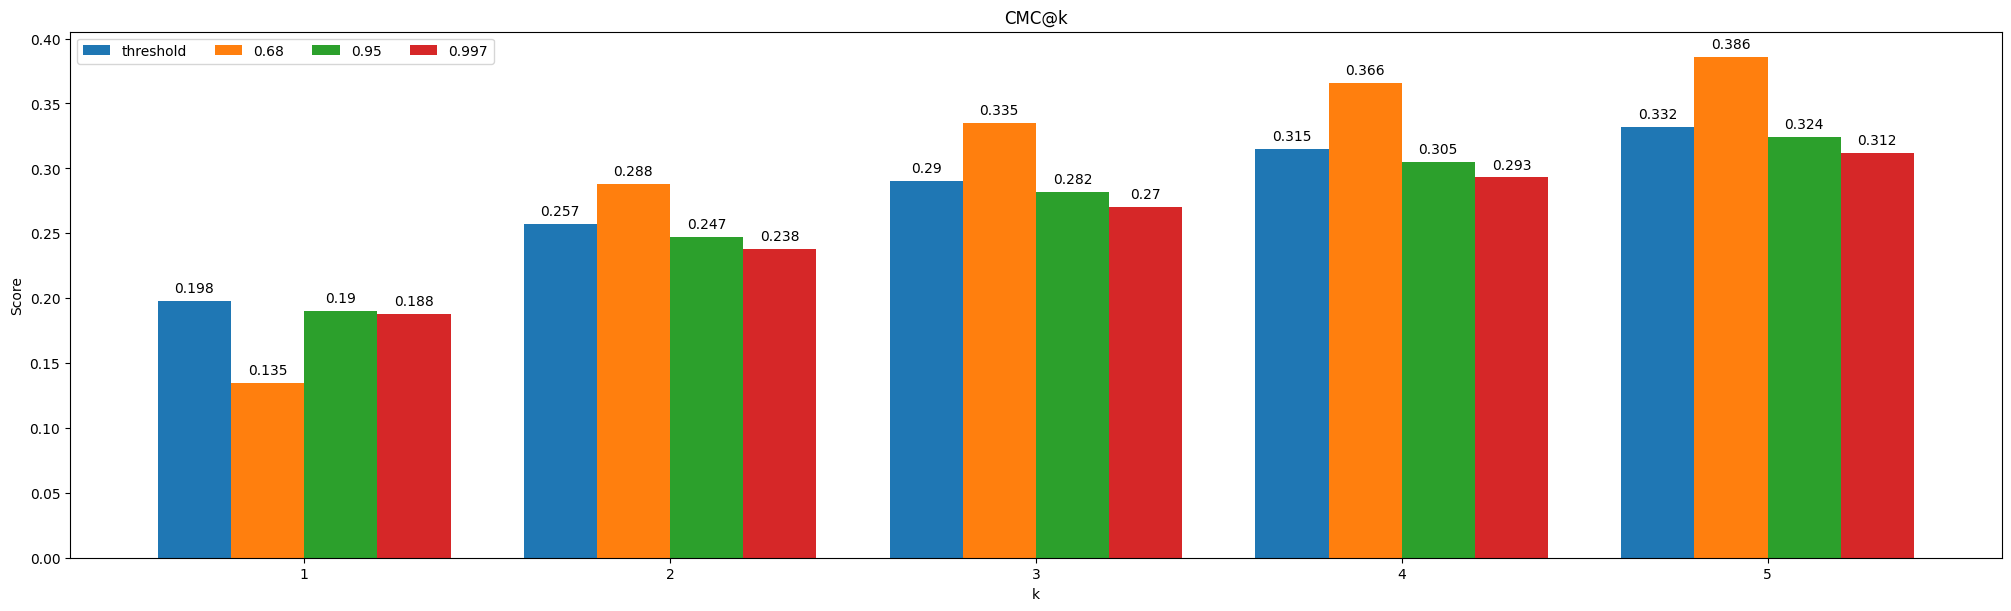

In [49]:
# CMC@k
plot_multiple_bar(
    values=cmc_values,
    x_values=top_k,
    xlabel='k',
    ylabel='Score',
    title='CMC@k'
)

#### mAP@k

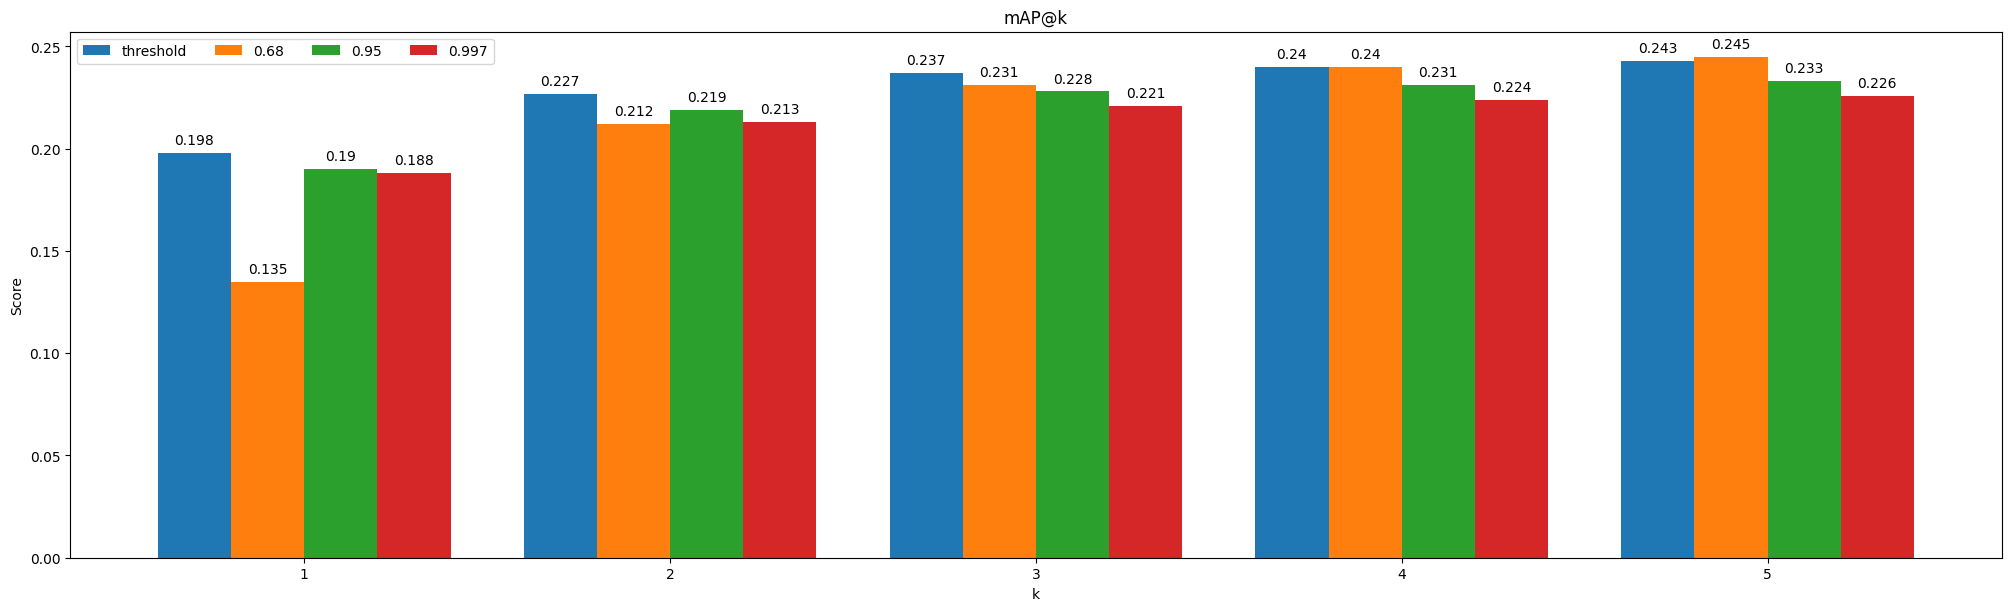

In [50]:
# mAP@k
plot_multiple_bar(
    values=map_values,
    x_values=top_k,
    xlabel='k',
    ylabel='Score',
    title='mAP@k'
)

#### Accuracy

To compare the candidate's choice between 1-knn and n-knn. If n-knn, the lynx_id of the current image will be the one found most often among the neighbours.

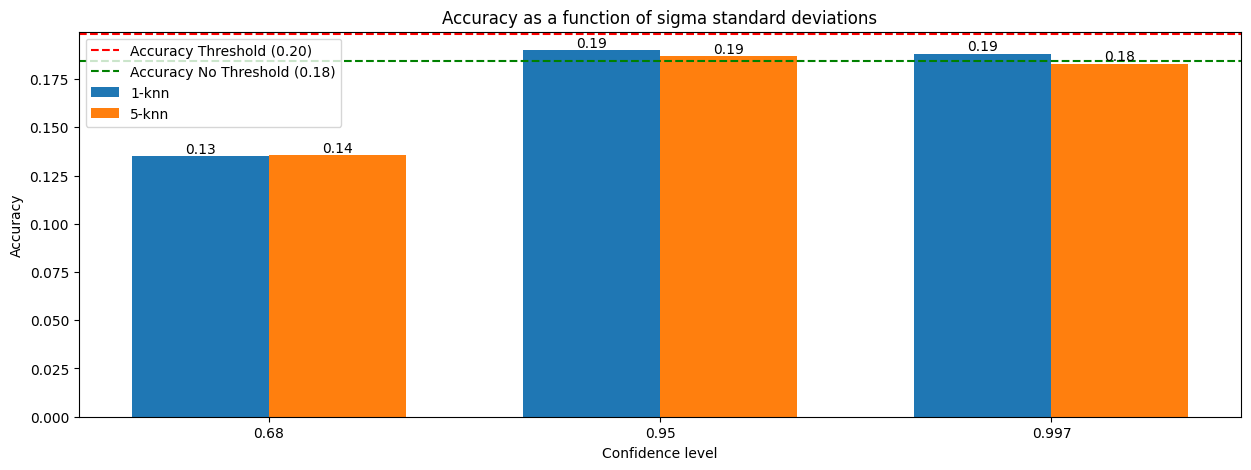

In [51]:
# Accuracy plot
accuracy_list_t = list(zip(*accuracy_list))

plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots()

width = 0.35

# Gaussian
bar1 = ax.bar(range(len(accuracy_list)), accuracy_list_t[0], width=width, label='1-knn')
bar2 = ax.bar([x + width for x in range(len(accuracy_list))], accuracy_list_t[1], width=width, label=f'{n_neighbors}-knn')

# Classic threshold
ax.axhline(y=accuracy_threshold, color='r', linestyle='--', label=f'Accuracy Threshold ({accuracy_threshold:.2f})')
ax.legend()

# No threshold
ax.axhline(y=accuracy_no_threshold, color='g', linestyle='--', label=f'Accuracy No Threshold ({accuracy_no_threshold:.2f})')
ax.legend()

ax.legend()

ax.set_xticks([x + width / 2 for x in range(len(accuracy_list))])
ax.set_xticklabels(confidence_levels)
ax.set_xlabel('Confidence level')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of sigma standard deviations')

ax.legend()

def add_text_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_text_labels(bar1)
add_text_labels(bar2)

plt.show()